# Contributions
There are three main contributions implemented in this project. A data generator provides sequential data given old predictions at each time step. The plot generator implements the the loop by repedeatly sampling new data, evaluating metrics and finally plotting the results. Wrapper classes wrap methods from the aif360 framework to make them usable for the plot generation. This section describes the contributions formally. Code examples are provided in the jupyter notebook for the next section.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt 

# 1. Data Generation
The data $X^{(t)}, A^{(t)}$ and $Y^{(t)}$ at time step $t$ is assumed to be distributed according to some distribution $\pi(X^{(t-1)}, A^{(t-1)},Y^{(t-1)})$. The features $X^{(t-1)}$ and $X^{(t)}$ between two different time step should be similar and the true label $Y^{(t)}$ must be predictable from $X^{(t)}$. 

The data generator is implemented by initially sampling the unprotected features $X$ from two different bivariate gaussians. Individuals with a positive label are sampled from a gaussian with mean $\mu _{pos}$ and negative labeled individuals from mean $\mu_{neg}$. 

The protected attribute $A$ is constant over time and only sampled in the first step. To account for discrimination
in the initial data generation step more individuals from the protected group are sampled from the negative cluster, but the data generator does not assume an actual causality between the protected feature and the positive label.

Similarity of features between two different time steps is achieved by sampling new points around the previous points.

The overall setup for the data generation is:

*Initial Step:* **Inputs**: $\mu_{pos}$, \$\mu_{neg}$, $\Sigma_{pos}$, $\Sigma_{neg}$, ***num_positive***, ***num_negative*** , ***discrimination_factor***

1. Sample ***num_positive***   $\cdot$ ***discrimination_factor***     from  $\mathcal{N}(X^{(t)}, \mu _{pos}, \Sigma _{pos})$
1. Sample ***num_positive***   $\cdot$ ***(1-discrimination_factor)*** from  $\mathcal{N}(X^{(t)}, \mu _{pos}, \Sigma _{pos})$
1. Sample ***num_positive***** $\cdot$ ***(1-discrimination_factor)*** from  $\mathcal{N}(X^{(t)}, \mu _{neg}, \Sigma _{neg})$
1. Sample ***num_negative***   $\cdot$ ***discrimination_factor***     from  $\mathcal{N}(X^{(t)}, \mu _{neg}, \Sigma _{neg})$ 

*Dynamic Step:* **Inputs**: $\Sigma_{pos}$, $\Sigma_{neg}$, $\Sigma_{local}$, ***step_size***

For each individual $i$:

   1. Compute $\mu _{new}$
   1. Sample the new features $X_i^{(t)}$ from $\mathcal{N}(X^{(t)}, \mu _{new}, \Sigma _{local})$
   1. Assign  $Y_i^{(t)}$ to the label of the closer cluster $\Sigma_{pos}$ or $\Sigma_{neg}$

To account for the dynamics, individuals move towards the negative or positive cluster depending on previous predictions:

$$\mu_{new}=\mathcal{N}\left( x_i^{(t)};~ \overline{x}_{i-1} + \alpha \cdot \vec{v} \cdot \sum _ {j \in G} \sum _ {k=1} ^{n} \hat{y} _j ^{(t-k)},~ \sigma \right)$$


Two different assumptions about the dynamics of the data generation are made (the Group $G$ in this case).

## Assumption 1: Positive Decisions only Affect Individuals
The probability for a positive label depends only on the predictions for the individual itself. For individual $i$ this means $G_i=\{i\}$.

## Assumptions 2: Positive Decisions Affect the whole Group
The whole group sharing the protected attribute benefits from positive decisions for individuals. For individual $i$ this means  $G_i=\{j | A_i^{(t)} = A_j^{(t)} \}$.

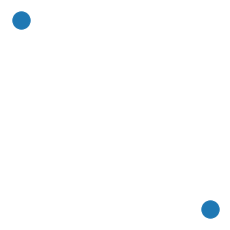

In [5]:
G = nx.MultiDiGraph()

G.add_node(1)
G.add_node(2)


plt.figure(figsize=(3,3))
nx.draw(G)

# 2. Metric and Prediction Function
To avoid re-implementation of metrics and decision functions, wrappers for AIF360 functions and metrics provided.

# 3. Plot Generator
Finally, the plot generator runs the long term simulation by repeadeatly sampling new data, running predictions and computing the metric. To estimate the impact of decision rules a baseline data pipeline constantly generates data assuming all previous decisions were positive. The pseudo code for the generator would be:

**Input:** *Metric, DecisionFunction, DataGenerator, Steps*

    X_old, A_old, Y_old = DataGenerator.InitializeData
    X_base_old, A_base_old, Y_base_old = X_old, A_old, Y_old 

    TrueMetric.append(Metric(X, A, Y))
    BaselineMetric.append(Metric(X_base, A_base, Y_base))

    For s in Steps:
        X_new, A_new, Y_new = DataGenerator.Sample(X_old, A_old, Y_old)
        TrueMetric.append(Metric(X_new, A_new, Y_new))

        Y_pos = PositiveLabel of shape Y_old
        X_base_new, A_base_new, Y_base_new = DataGenerator.Sample(X_base_old, A_base_old, Y_pos)
        
        BaselineMetric.append(Metric( X_base_new, A_base_new, Y_base_new))

        Append X_new, ..., X_base_new, Y_base_new to the old data

**Output:** *Plot(TrueMetric, BaselineMetric)*
